In [8]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from collections import namedtuple
from IPython.display import clear_output
from tqdm.notebook import tqdm
from numpy.typing import NDArray
from typing import Callable

from scipy.optimize import minimize
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit import Parameter, Instruction
from qiskit.circuit.library import RXGate, RYGate, RZGate, CXGate, CZGate, IGate
from qiskit_aer import AerSimulator

In [2]:
# from qml.model.gate import GateInfo

In [17]:
GateInfo = namedtuple(
    'GateInfo',
    ['gate_class', 'trainable', "multi_bit", "qargs"]
)

In [18]:
def single_qubit_qargs(qc: QuantumCircuit, qubit_idx: int) -> list:
    return [qc.qubits[qubit_idx]]

In [19]:
def generate_double_qubit_args(spread: int = 1) -> Callable:
    def double_qubit_args(qc: QuantumCircuit, qubit_idx: int) -> list:
        return [
            qc.qubits[qubit_idx],
            qc.qubits[(qubit_idx+spread) % qc.num_qubits],
        ]
    return double_qubit_args

In [20]:
GATESET_FOR_3_QUBIT = dict(
    rx=GateInfo(RXGate, True, False, single_qubit_qargs),
    ry=GateInfo(RYGate, True, False, single_qubit_qargs),
    rz=GateInfo(RZGate, True, False, single_qubit_qargs),
    cz=GateInfo(CZGate, False, True, generate_double_qubit_args(1)),
)

In [21]:
qc = QuantumCircuit(3)
fn = generate_double_qubit_args(1)
fn(qc, 2)

[Qubit(QuantumRegister(3, 'q'), 2), Qubit(QuantumRegister(3, 'q'), 0)]

In [22]:
class Gate:
    
    def __init__(
            self,
            gate: Instruction,
            trainable: bool,
            multi_qubit: bool,
            qubit: int,
            qargs_func: Callable
    ):
        self._gate = gate
        self._trainable = trainable
        self._multi_qubit = multi_qubit
        self._qubit = qubit
        self._qargs_func = qargs_func
        
    def apply_to_qc(self, qc: QuantumCircuit):
        qargs = self._qargs_func(qc, self._qubit)
        qc.append(self._gate, qargs)
    
    @staticmethod
    def new_with_info(info: GateInfo, qubit: int, parameter: Parameter = None):
        gate = info.gate_class() if parameter is None else info.gate_class(parameter)
        return Gate(
            gate, info.trainable, info.multi_bit, qubit
        )
    
    @property
    def gate(self):
        return self._gate
    
    @property
    def trainable(self):
        return self._trainable
    
    @property
    def multi_qubit(self):
        return self._multi_qubit
    
    @property
    def qubit(self):
        return self._qubit

0 <class 'int'>


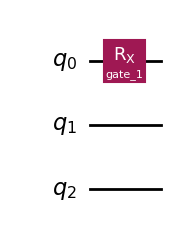

In [30]:
info = GATESET_FOR_3_QUBIT["rx"]
gate = Gate(
    info.gate_class(Parameter("gate_1")),
    info.trainable,
    info.multi_bit,
    np.random.randint(3),
    info.qargs,
)
print(gate.qubit, type(gate.qubit))
qc = QuantumCircuit(3)
gate.apply_to_qc(qc)
qc.draw(output="mpl")